# Deep learning framework example

This notebook demonstrates how to use the deeplearning API to train and test the model on the [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris).

To install the necessary software, use `make deps` in the root directory of the project.  If you don't have make installed or don't want to use it, then use:

`pip install -r src/python/requirements.txt`

**Note**: it is not necessary to install the `zensols.deeplearn` package to run this notebook.


## What is demoed

This notebook shows how to create an executor directly.  However, an easier more client friendly facade is available and given in the *mnist* notebook.

Also see the the *debug* notebook, which demostrates how to debug a model.

In [1]:
# set up notebook environment
import sys
app_root_dir = '..'
sys.path.append(app_root_dir + '/src/python')
sys.path.append(app_root_dir + '/test/python')

## Create the object factory

This creates a factoty that instantiates Python objects using a simple configuration (INI).  This removes much of the complexity of creating and "hooking up" all the instances.

In [2]:
import logging
from pathlib import Path
from zensols.config import ExtendedInterpolationEnvConfig as AppConfig
from zensols.config import ImportConfigFactory
from zensols.deeplearn import TorchConfig
from zensols.deeplearn.result import ModelResultGrapher

# initialze PyTorch and set the random seed so things are predictable
TorchConfig.init()

temp_dir = Path('../target')
if temp_dir.is_dir():
    import shutil
    print(f'removing previous results in {temp_dir}')
    shutil.rmtree(temp_dir)

# configure logging
logging.basicConfig(format='%(asctime)-15s %(name)s [%(levelname)s]: %(message)s',
                    level=logging.WARNING)
for name in ['zensols.deeplearn.result',
             'zensols.deeplearn.model.facade',
             'zensols.deeplearn.batch.stash']:
    logging.getLogger(name).setLevel(logging.INFO)

# configure the environment
config = AppConfig(app_root_dir + '/test-resources/iris/iris.conf',
                   env={'app_root': app_root_dir})

# create a factoty that instantiates Python objects using a simple configuration (INI)
factory = ImportConfigFactory(config)

removing previous results in ../target


## Create the model executor

Use the factory to create the model executor (see the `executor` section of `test-resources/iris/iris.conf`).  The `write` method gives statistics on the data set that is configured on the executor.

In [3]:
executor = factory('executor')
executor.write()

2023-12-02 16:23:05,558 zensols.deeplearn.batch.stash [INFO]: batch_dataset_stash: creating keys with (<class 'zensols.dataframe.stash.DefaultDataframeStash'>) using batch size of 20
2023-12-02 16:23:05,559 zensols.deeplearn.batch.stash [INFO]: keys for split dev: 12
2023-12-02 16:23:05,560 zensols.deeplearn.batch.stash [INFO]: keys for split test: 25
2023-12-02 16:23:05,560 zensols.deeplearn.batch.stash [INFO]: keys for split train: 113
2023-12-02 16:23:05,560 zensols.deeplearn.batch.stash [INFO]: created 9 each set limited with 9223372036854775807 with batch_limit=9223372036854775807


model: Iris
feature splits:
    data frame splits:
    dev: 12 (8.0%)
    test: 25 (16.7%)
    train: 113 (75.3%)
    total: 150
batch splits:
    split stash splits:
        dev: 1 (11.1%)
        test: 2 (22.2%)
        train: 6 (66.7%)
        total: 9
    total this instance: 9
    keys consistent: True


## Print the model

Every time the executor is told to train, it creates a new model.  It also stores this model to the disk every time the validation loss drops.  The method that controls the creation is `_create_model`, and not meant to be called by the client.  Note this creates a new PyTorch `torch.nn.Module` every time and isn't the same instance used by the executor.

In this case, a four deep fully connected network is created and fanned out from the 4 features (from four columns from the CSV file) to 20.  This is then reduce to the output layer having three neurons indicating which type of flower (setosa, versicolor, or virginica).

In [4]:
print(executor._create_model())

IrisNetwork(
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): DeepLinear(
    (dropout): Dropout(p=0.1, inplace=False)
    (lin_layers): Sequential(
      (0): Linear(in_features=4, out_features=5, bias=True)
      (1): Linear(in_features=5, out_features=1, bias=True)
      (2): Linear(in_features=1, out_features=3, bias=True)
    )
  )
)


## Train and test the model

This trains the model on the Iris (flower) data set and prints the results.  The PyTorch model itself is also printed.

2023-12-02 16:23:08,965 zensols.deeplearn.batch.stash [INFO]: loaded batch 3 (train) in 0ms
2023-12-02 16:23:08,967 zensols.deeplearn.batch.stash [INFO]: loaded batch 4 (train) in 0ms
2023-12-02 16:23:08,968 zensols.deeplearn.batch.stash [INFO]: loaded batch 5 (train) in 0ms
2023-12-02 16:23:08,970 zensols.deeplearn.batch.stash [INFO]: loaded batch 6 (train) in 0ms
2023-12-02 16:23:08,972 zensols.deeplearn.batch.stash [INFO]: loaded batch 7 (train) in 0ms
2023-12-02 16:23:08,973 zensols.deeplearn.batch.stash [INFO]: loaded batch 8 (train) in 0ms
2023-12-02 16:23:08,975 zensols.deeplearn.batch.stash [INFO]: loaded batch 0 (dev) in 0ms
tr:7.6712|va min:3.3361|va:3.8105 /\: 100%|██████████| 15/15 [00:00<00:00, 144.12it/s]
2023-12-02 16:23:09,341 zensols.deeplearn.batch.stash [INFO]: loaded batch 1 (test) in 0ms
2023-12-02 16:23:09,343 zensols.deeplearn.batch.stash [INFO]: loaded batch 2 (test) in 0ms


Name: Iris: 1
Run index: 2
Learning rate: 0.1
    train:
        started: 12/02/2023 16:23:09:236695
        ended: 12/02/2023 16:23:09:332923
        batches: 6
        ave data points per batch/total: 18.8/113
        min/ave/max loss: 3.47808/7.19005/12.09810
    validation:
        started: 12/02/2023 16:23:09:263356
        ended: 12/02/2023 16:23:09:333046
        batches: 1
        ave data points per batch/total: 12.0/12
        converged/epochs: 13/15
        min/ave/max loss: 3.33611/3.33611/3.33611
        accuracy: 0.750 (0/12)
        micro: F1: 0.750, precision: 0.750, recall: 0.750
        macro: F1: 0.608, precision: 0.567, recall: 0.667
        weighted: F1: 0.647, precision: 0.575, recall: 0.750
    test:
        started: 12/02/2023 16:23:09:343996
        ended: 12/02/2023 16:23:09:344469
        batches: 2
        ave data points per batch/total: 12.5/25
        min/ave/max loss: 1.03140/5.09530/9.15921
        accuracy: 0.680 (0/25)
        micro: F1: 0.680, precis

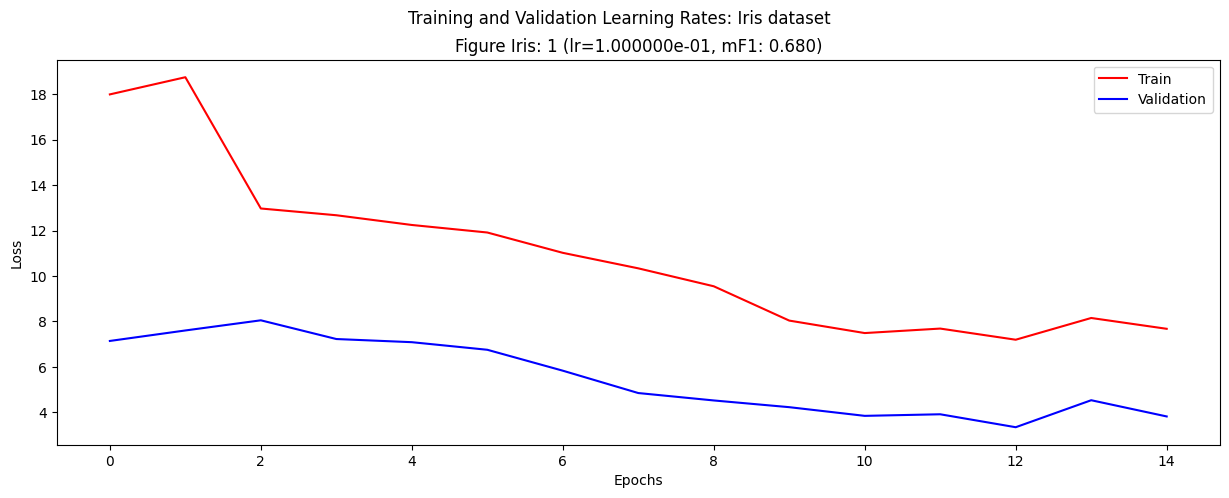

In [5]:
# tell the executor to give us console output
executor.progress_bar = True

# train the model
executor.train()

# test the model
res = executor.test()

# write a summary of the results
res.write()

# graph the results
grapher = ModelResultGrapher('Iris dataset', [15, 5])
grapher.plot_loss([res])

## Create the model facade

An easier wasy to use the executor is with a *facade*.  A `ModelFacade` provides easy to use client entry points to the model executor, which trains, validates, tests, saves and loads the model.  Create the facade with a factory, which in turn creates the executor.  The statistics on the data set that is configured on the executor is, by default, printed to standard out.  You can set the `writer` property to `None` on the facade to disable this.

In [6]:
from dataclasses import dataclass
from zensols.deeplearn.model import ModelFacade

@dataclass
class IrisModelFacade(ModelFacade):
    def _configure_debug_logging(self):
        super()._configure_debug_logging()
        logging.getLogger('iris.model').setLevel(logging.DEBUG)
        
# deallocate the previous executor
executor.deallocate()
# create the facade
facade = IrisModelFacade(config)

## Fine tune setting hyperparameters

Now that we have our model training and we have evaluated the results, we see the validation loss is very spiky.  This means our learning rate is probably too high as when it moves during stochastic gradient descent it is "jumping" too far and back up the error surface.

To fix that, let's decrease the learning rate.  We can do that by adjusting the hyperparameters directly on the facade.  In fact, the purpose of the facade is to make changes easily such as this.

Notice that the facade prints the output with a correctly configured scroll bar by default.  Output can be disabled by setting the `writer` attribute/initializer parameter to `None`.  The progress bar and columns are set with the `progress_bar` and `progress_bar_col` attributes.

In [7]:
# set the number of epochs and learning rate, which are both model parameters
facade.epochs = 20
facade.learning_rate = .01
# train and test the model
facade.train()
facade.test()
# display the results in this cell
facade.write_result()

2023-12-02 16:23:09,516 zensols.deeplearn.model.facade [INFO]: creating new executor
2023-12-02 16:23:09,519 zensols.deeplearn.model.facade [INFO]: training...
2023-12-02 16:23:09,523 zensols.deeplearn.batch.stash [INFO]: loaded batch 3 (train) in 0ms
2023-12-02 16:23:09,527 zensols.deeplearn.batch.stash [INFO]: loaded batch 4 (train) in 0ms
2023-12-02 16:23:09,528 zensols.deeplearn.batch.stash [INFO]: loaded batch 5 (train) in 0ms
2023-12-02 16:23:09,532 zensols.deeplearn.batch.stash [INFO]: loaded batch 6 (train) in 0ms
2023-12-02 16:23:09,534 zensols.deeplearn.batch.stash [INFO]: loaded batch 7 (train) in 0ms
2023-12-02 16:23:09,536 zensols.deeplearn.batch.stash [INFO]: loaded batch 8 (train) in 0ms
2023-12-02 16:23:09,538 zensols.deeplearn.batch.stash [INFO]: loaded batch 0 (dev) in 0ms
tr:8.4333|va min:  4.77|va:4.6793 \/:  95%|█████████▌| 19/20 [00:00<00:00, 164.19it/s]2023-12-02 16:23:09,676 zensols.deeplearn.model.facade [INFO]: trained in 15ms
tr:8.4333|va min:  4.77|va:4.6793

Name: Iris: 1
Run index: 2
Learning rate: 0.01
    train:
        started: 12/02/2023 16:23:09:542239
        ended: 12/02/2023 16:23:09:664192
        batches: 6
        ave data points per batch/total: 18.8/113
        min/ave/max loss: 5.19961/8.43325/13.29058
    validation:
        started: 12/02/2023 16:23:09:547098
        ended: 12/02/2023 16:23:09:664336
        batches: 1
        ave data points per batch/total: 12.0/12
        converged/epochs: 20/20
        min/ave/max loss: 4.67933/4.67933/4.67933
        accuracy: 0.750 (0/12)
        micro: F1: 0.750, precision: 0.750, recall: 0.750
        macro: F1: 0.608, precision: 0.567, recall: 0.667
        weighted: F1: 0.647, precision: 0.575, recall: 0.750
    test:
        started: 12/02/2023 16:23:09:685242
        ended: 12/02/2023 16:23:09:685643
        batches: 2
        ave data points per batch/total: 12.5/25
        min/ave/max loss: 1.79437/4.91651/8.03866
        accuracy: 0.680 (0/25)
        micro: F1: 0.680, preci

## Network parameters

While we're at it, let's also adjust the drop out, which is a network settings, to see if we can get better results.  Also note that the model converged pretty late indicating we aren't over training, so add more epochs.

2023-12-02 16:23:09,712 zensols.deeplearn.model.facade [INFO]: training...
tr:6.0708|va min:2.6925|va: 2.737 /\: 100%|█████████▉| 999/1000 [00:06<00:00, 171.62it/s]2023-12-02 16:23:16,657 zensols.deeplearn.model.facade [INFO]: trained in 6.94s
tr:6.0708|va min:2.6925|va: 2.737 /\: 100%|██████████| 1000/1000 [00:06<00:00, 143.98it/s]
2023-12-02 16:23:16,742 zensols.deeplearn.model.facade [INFO]: testing...
2023-12-02 16:23:16,743 zensols.deeplearn.model.facade [INFO]: tested in 0ms
2023-12-02 16:23:16,743 zensols.deeplearn.model.facade [INFO]: load previous results
2023-12-02 16:23:16,812 zensols.deeplearn.result.manager [INFO]: copying model ../target/iris/model -> ../target/iris/results/iris-1.model
2023-12-02 16:23:16,815 zensols.deeplearn.result.manager [INFO]: saving text results to ../target/iris/results/iris-1.txt


Name: Iris: 1
Run index: 2
Learning rate: 0.005
    train:
        started: 12/02/2023 16:23:09:715225
        ended: 12/02/2023 16:23:16:348021
        batches: 6
        ave data points per batch/total: 18.8/113
        min/ave/max loss: 2.36629/5.31010/10.32054
    validation:
        started: 12/02/2023 16:23:09:718929
        ended: 12/02/2023 16:23:16:348115
        batches: 1
        ave data points per batch/total: 12.0/12
        converged/epochs: 962/1000
        min/ave/max loss: 2.69255/2.69255/2.69255
        accuracy: 1.000 (0/12)
        micro: F1: 1.000, precision: 1.000, recall: 1.000
        macro: F1: 1.000, precision: 1.000, recall: 1.000
        weighted: F1: 1.000, precision: 1.000, recall: 1.000
    test:
        started: 12/02/2023 16:23:16:742783
        ended: 12/02/2023 16:23:16:743253
        batches: 2
        ave data points per batch/total: 12.5/25
        min/ave/max loss: 0.91926/3.94936/6.97946
        accuracy: 0.880 (0/25)
        micro: F1: 0.880, p

2023-12-02 16:23:17,008 zensols.deeplearn.result.manager [INFO]: saving json results to ../target/iris/results/iris-1.json
2023-12-02 16:23:17,149 zensols.deeplearn.result.plot [INFO]: saving results graph to ../target/iris/results/iris-1.png


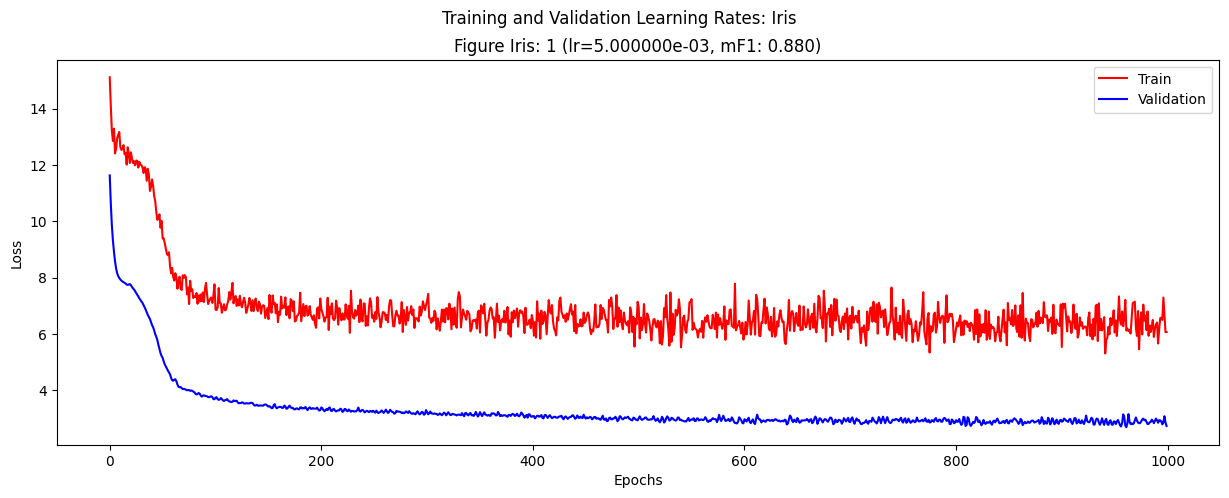

In [8]:
# turn off output so we can get just the final results later with `write_result`
facade.writer = None
# set network parameter `dropout` and model settings to achieve better performance
facade.dropout = 0.1
# set lower learning rate and compensate with epochs in case learning is slower
facade.epochs = 1000
facade.learning_rate = .005
# train and test again
facade.train()
facade.test()
# display the results in this cell
facade.write_result()
# plot results
facade.plot_result()
# now since we like our results, save them to disk
facade.persist_result()

## Predictions

The executor contains the results from the last run, in additional to saving it.  In our case, we have the same instance of the model we just tested, which contains not only the performance metrics, but the predictions themselves.  Use `get_predictions` to get a Pandas `pd.DataFrame` for the results.

In [9]:
from iris.model import IrisDataPoint

# optionally, we can transform the data point instance used, otherwise it defaults to `str`
def map_data_point(dp: IrisDataPoint):
    """Map the data point's Pandas row information (pd.Series) to key/value string.
    
    :param dp: the data point created by the ``iris_dataset_stash`` as defined in the configuration
    
    """
    s = ', '.join(map(lambda x: f'{x[0]}={x[1]}', dp.row.items()))
    return dp.row['sepal_length'], dp.row['sepal_width'], dp.row['petal_length'], dp.row['petal_width']
facade.get_predictions(column_names=['sepal length', 'sepal width', 'petal length', 'petal width'], transform=map_data_point)

2023-12-02 16:23:17,340 zensols.deeplearn.batch.stash [INFO]: loaded batch 1 (test) in 0ms
2023-12-02 16:23:17,343 zensols.deeplearn.batch.stash [INFO]: loaded batch 2 (test) in 0ms


,id,label,pred,correct,sepal length,sepal width,petal length,petal width,batch_id
0,17,setosa,setosa,True,5.1,3.5,1.4,0.3,1
1,30,setosa,setosa,True,4.8,3.1,1.6,0.2,1
2,31,setosa,setosa,True,5.4,3.4,1.5,0.4,1
3,33,setosa,setosa,True,5.5,4.2,1.4,0.2,1
4,41,setosa,setosa,True,4.5,2.3,1.3,0.3,1
5,43,setosa,setosa,True,5.0,3.5,1.6,0.6,1
6,45,setosa,setosa,True,4.8,3.0,1.4,0.3,1
7,46,setosa,setosa,True,5.1,3.8,1.6,0.2,1
8,48,setosa,setosa,True,5.3,3.7,1.5,0.2,1
9,49,setosa,setosa,True,5.0,3.3,1.4,0.2,1


In [10]:
from zensols.persist import dealloc
from zensols.deeplearn.model import ModelFacade
from pathlib import Path

# deallocate the previous facade
facade.deallocate()
path = Path('../target/iris/results/iris-1.model')
# create a new facade wrapped in a deallocation block
# (it will be deallocated even in an error generated in the block)
with dealloc(ModelFacade.load_from_path(path)) as facade:
    facade.write_result()
# note that no test results are given since this model was saved during
# training after achieving the lowest validation loss

2023-12-02 16:23:17,359 zensols.deeplearn.model.facade [INFO]: loading from facade from ../target/iris/results/iris-1.model
2023-12-02 16:23:17,525 zensols.deeplearn.model.facade [INFO]: load previous results


Name: Iris: 1
Run index: 2
Learning rate: 0.005
    train:
        started: 12/02/2023 16:23:09:715225
        ended: 12/02/2023 16:23:16:348021
        batches: 6
        ave data points per batch/total: 18.8/113
        min/ave/max loss: 2.36629/5.31010/10.32054
    validation:
        started: 12/02/2023 16:23:09:718929
        ended: 12/02/2023 16:23:16:348115
        batches: 1
        ave data points per batch/total: 12.0/12
        converged/epochs: 962/1000
        min/ave/max loss: 2.69255/2.69255/2.69255
        accuracy: 1.000 (0/12)
        micro: F1: 1.000, precision: 1.000, recall: 1.000
        macro: F1: 1.000, precision: 1.000, recall: 1.000
        weighted: F1: 1.000, precision: 1.000, recall: 1.000
    test:
        no results


In [11]:
# we can also revive the model as a facade to test, then we'll get the test results
with dealloc(ModelFacade.load_from_path(path)) as facade:
    facade.writer = None
    facade.test()
    facade.write_result(include_converged=True)

2023-12-02 16:23:17,536 zensols.deeplearn.model.facade [INFO]: loading from facade from ../target/iris/results/iris-1.model
2023-12-02 16:23:17,842 zensols.deeplearn.model.facade [INFO]: testing...
2023-12-02 16:23:17,844 zensols.deeplearn.batch.stash [INFO]: loaded batch 1 (test) in 0ms
2023-12-02 16:23:17,846 zensols.deeplearn.batch.stash [INFO]: loaded batch 2 (test) in 0ms
2023-12-02 16:23:17,847 zensols.deeplearn.model.facade [INFO]: tested in 0ms
2023-12-02 16:23:17,847 zensols.deeplearn.model.facade [INFO]: load previous results


Name: Iris: 1
Run index: 2
Learning rate: 0.005
    train:
        started: 12/02/2023 16:23:09:715225
        ended: 12/02/2023 16:23:16:348021
        batches: 6
        ave data points per batch/total: 18.8/113
        average over epoch:
            min/ave/max loss: 5.31010/6.87711/10.32054
            accuracy: 0.802 (0/113000)
            micro: F1: 0.802, precision: 0.802, recall: 0.802
            macro: F1: 0.799, precision: 0.801, recall: 0.804
            weighted: F1: 0.798, precision: 0.801, recall: 0.802
            epoch details:
                index: 0
                batch IDs: 3,4,5,6,7,8
                data point count per batch: 20,20,20,20,20,13
        converged epoch:
            min/ave/max loss: 2.36629/5.31010/10.32054
            accuracy: 0.903 (0/113)
            micro: F1: 0.903, precision: 0.903, recall: 0.903
            macro: F1: 0.901, precision: 0.909, recall: 0.905
            weighted: F1: 0.900, precision: 0.909, recall: 0.903
    validation:
 